In [1]:
import os
import sys

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor

PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), '../'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
    
from server.ml_models.all_model import AllModel, AllModelData
from src.model.metrics import measure_estimators, yearly_performance_scores
from src.model.charts import graph_cv_model_performance, graph_yearly_model_performance

np.random.seed(42)

class AveragingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        self.estimators = estimators

    def fit(self, X, y):
        for estimator in self.estimators:
            estimator.fit(X, y)
            
        return self
            
    def predict(self, X):
        predictions = []

        for estimator in self.estimators:
            predictions.append(estimator.predict(X))

        return np.array(predictions).mean(axis=0)

    
class StackingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, meta_estimator):
        self.estimators = estimators
        self.meta_estimator = meta_estimator

    def fit(self, X, y):
        predictions = []

        for idx, estimator in enumerate(self.estimators):
            estimator.fit(X, y)
            predictions.append(estimator.predict(X).rename(idx))

        X_all = pd.concat(predictions, axis=1)
        self.meta_estimator.fit(X_all, y)
            
        return self
            
    def predict(self, X):
        predictions = []

        for idx, estimator in enumerate(self.estimators):
            predictions.append(estimator.predict(X).rename(idx))

        X_all = pd.concat(predictions, axis=1)

        return self.meta_estimator.predict(X_all)

## Compare averaging, stacking, and bagging

In [2]:
# Take top-performing models from all data notebook (6.2-all-data-nn)

ESTIMATORS = [
    Ridge,
    GradientBoostingRegressor,
    LinearSVR,
    XGBRegressor,
]

models = []
data = AllModelData(train_years=(None, 2016))
features, labels = data.train_data()
X_train, X_test, y_train, y_test = train_test_split(features, labels)

for estimator in ESTIMATORS:
    model = AllModel(estimators=(StandardScaler(), estimator()), name=type(estimator).__name__)
    models.append(model)

all_model = AllModel()
bag_model = BaggingRegressor(base_estimator=AllModel())
avg_model = AveragingRegressor(models)
stack_model = StackingRegressor(models, make_pipeline(StandardScaler(), XGBRegressor()))

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/app/server/data_processors/feature_functions.py:476: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(["player_id", "year"], group_keys=True)
/app/server/data_processors/feature_functions.py:476: FutureWarning: 'year' is both an index level and a column label.
Defau

In [4]:
scores = measure_estimators(
    [('all', all_model), ('bag', bag_model), ('average', avg_model), ('stack', stack_model)],
    (X_train, X_test, y_train, y_test)
)
scores

Training all
all done
Training bag
bag done
Training average
average done
Training stack


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


stack done


,model,accuracy,error,std_accuracy,std_error,score_type
0,all,0.707996,26.675777,0.003157,0.285873,cv
1,bag,0.708040,26.633648,0.004055,0.254922,cv
2,average,0.710135,26.587980,0.003312,0.294731,cv
3,stack,0.708174,26.901035,0.001963,0.308948,cv
4,all,0.708690,26.614411,NaN,NaN,test
5,bag,0.708021,26.590343,NaN,NaN,test
6,average,0.708824,26.498845,NaN,NaN,test
7,stack,0.707620,26.681498,NaN,NaN,test


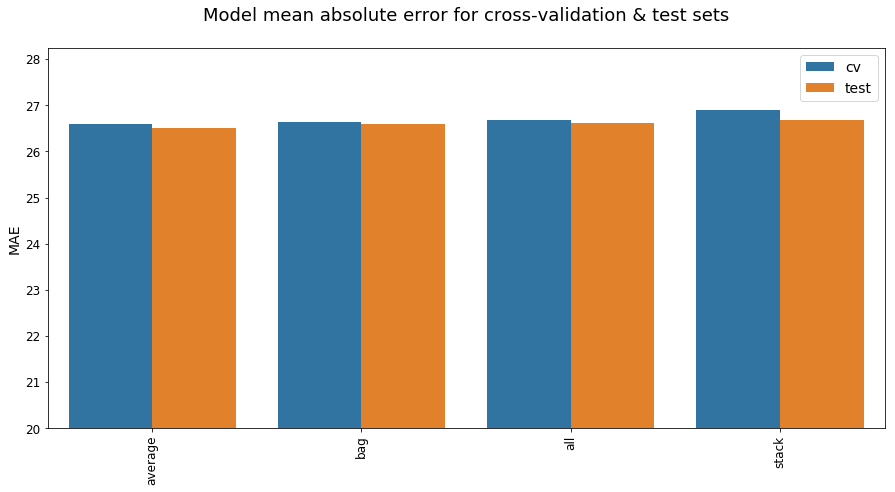

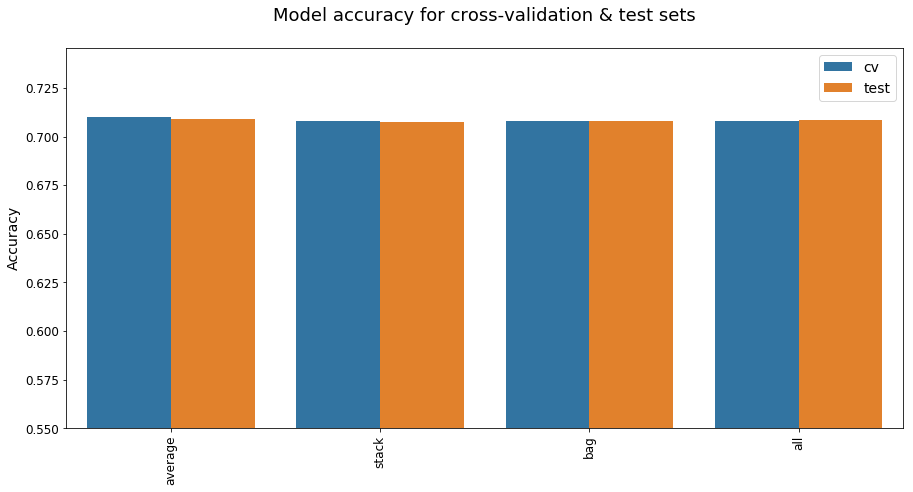

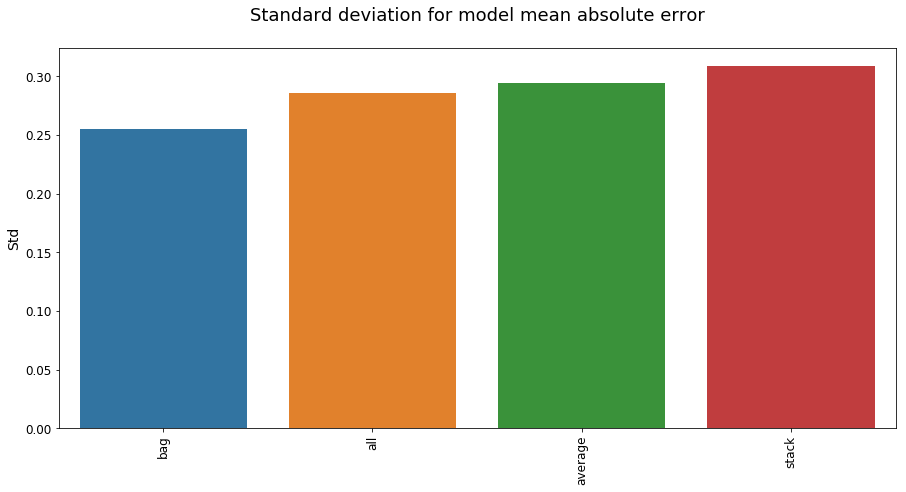

In [5]:
graph_cv_model_performance(scores)

### Averaging has best scores
They all are roughly equal, but averaging multiple models results in slightly lower error and slightly higher accuracy. However, bagging has the lowest STD, which might make it more consistent from year to year.

In [3]:
YEAR_ESTIMATORS = [
    ('all', all_model, False),
    ('average', avg_model, False),
    ('stack', stack_model, False),
    ('bag', bag_model, False)
]

year_scores = yearly_performance_scores(YEAR_ESTIMATORS, features, labels)
year_scores

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype float32, float64 were all convert

,accuracy,error,model,year
0,0.723077,30.612743,all,2011
1,0.751282,29.346211,average,2011
2,0.735897,30.825910,stack,2011
3,0.730769,30.293917,bag,2011
4,0.781553,28.431429,all,2012
5,0.766990,27.790045,average,2012
6,0.774272,28.769952,stack,2012
7,0.766990,28.456500,bag,2012
8,0.731884,26.947491,all,2013
9,0.731884,27.126535,average,2013


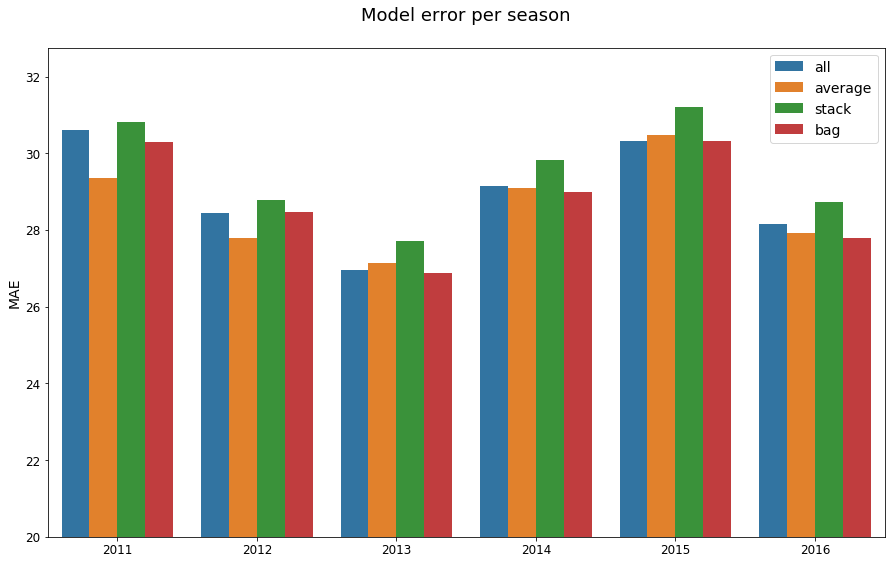

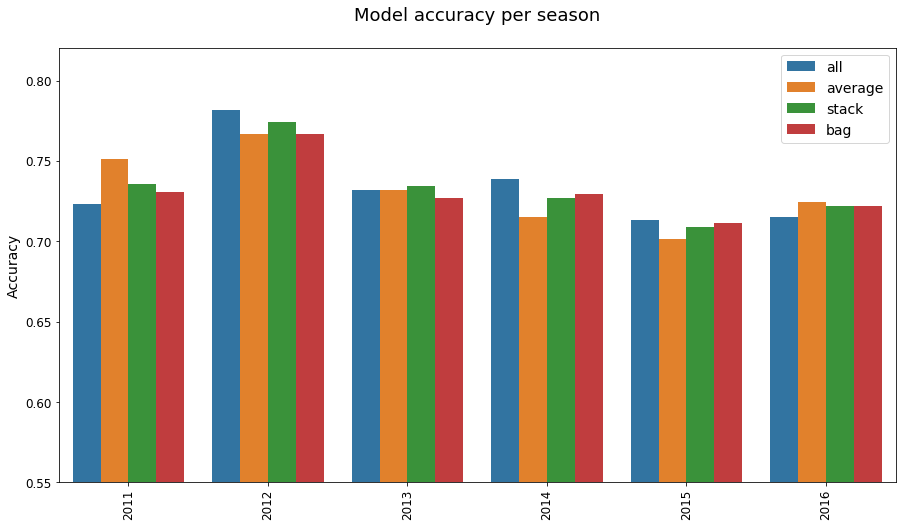

In [6]:
graph_yearly_model_performance(year_scores)

In [7]:
year_scores.groupby('model').mean()

,accuracy,error,year
model,,,
all,0.734035,28.933044,2013.5
average,0.731871,28.620735,2013.5
bag,0.731278,28.789467,2013.5
stack,0.733747,29.508525,2013.5


In [8]:
year_scores.groupby('model').std()

,accuracy,error,year
model,,,
all,0.025258,1.381807,1.870829
average,0.023971,1.231281,1.870829
bag,0.018885,1.372004,1.870829
stack,0.022137,1.348018,1.870829


### Averaging and bagging are close
Averaging has the best CV scores, which includes more data, but older years don't have betting data. For the yearly breakdown, averaging is a little better regarding MAE, but doesn't have very good accuracy relative to the other models. Bagging tends to have the best accuracy and is 2nd for MAE. However, accuracy has lower STD, which with the lower MAE kind of gives it the edge, but I've already changed my mind about 3 times...

## Averaging with Bagging

In [9]:
avbag_models = []

for estimator in ESTIMATORS:
    model = BaggingRegressor(
        base_estimator=AllModel(estimators=(StandardScaler(), estimator()), name=type(estimator).__name__)
    )
    avbag_models.append(model)

avbag_model = AveragingRegressor(avbag_models)

In [10]:
ab_scores = measure_estimators([('avg_bag', avbag_model)], (X_train, X_test, y_train, y_test))
scores2 = pd.concat([scores, ab_scores]).sort_values(['score_type', 'model'])
scores2

Training avg_bag
avg_bag done


,model,accuracy,error,std_accuracy,std_error,score_type
0,all,0.707996,26.675777,0.003157,0.285873,cv
2,average,0.710135,26.587980,0.003312,0.294731,cv
0,avg_bag,0.709778,26.577402,0.004097,0.279639,cv
1,bag,0.708040,26.633648,0.004055,0.254922,cv
3,stack,0.708174,26.901035,0.001963,0.308948,cv
4,all,0.708690,26.614411,NaN,NaN,test
6,average,0.708824,26.498845,NaN,NaN,test
1,avg_bag,0.707620,26.491155,NaN,NaN,test
5,bag,0.708021,26.590343,NaN,NaN,test
7,stack,0.707620,26.681498,NaN,NaN,test


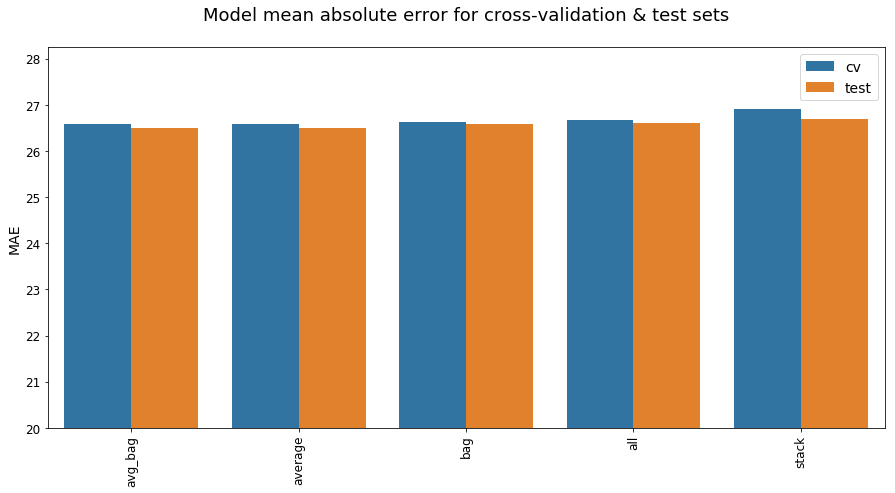

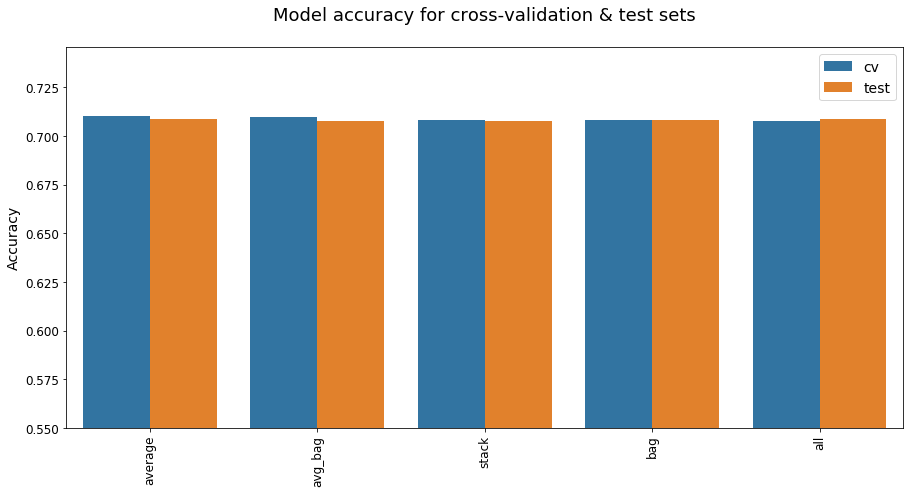

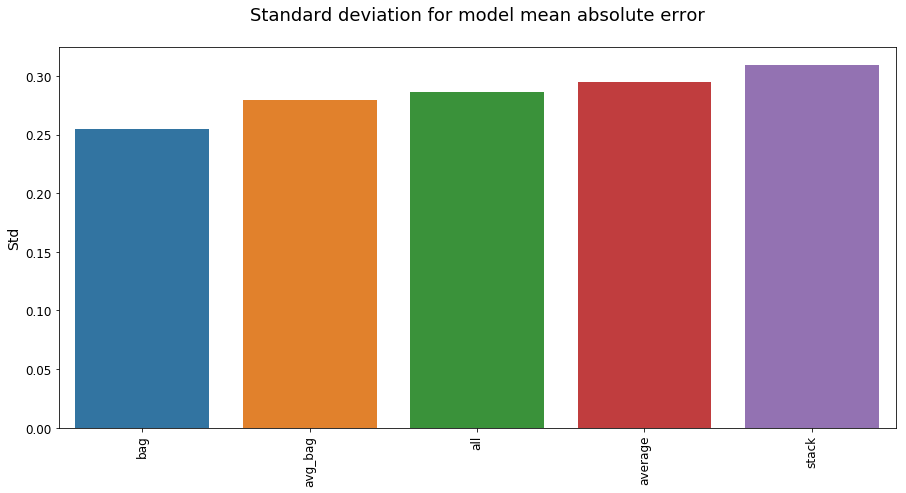

In [11]:
graph_cv_model_performance(scores2)

In [12]:
ab_year_scores = yearly_performance_scores([('avg_bag', avbag_model, False)], features, labels)
year_scores2 = pd.concat([year_scores, ab_year_scores]).sort_values(['year', 'model'])
year_scores2

,accuracy,error,model,year
0,0.723077,30.612743,all,2011
1,0.751282,29.346211,average,2011
0,0.751282,29.314066,avg_bag,2011
3,0.730769,30.293917,bag,2011
2,0.735897,30.825910,stack,2011
4,0.781553,28.431429,all,2012
5,0.766990,27.790045,average,2012
1,0.759709,28.063900,avg_bag,2012
7,0.766990,28.456500,bag,2012
6,0.774272,28.769952,stack,2012


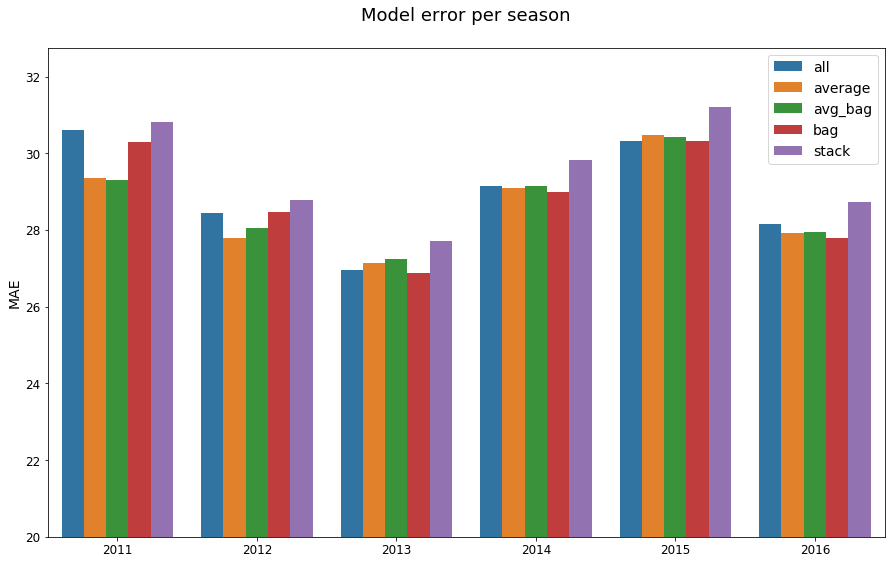

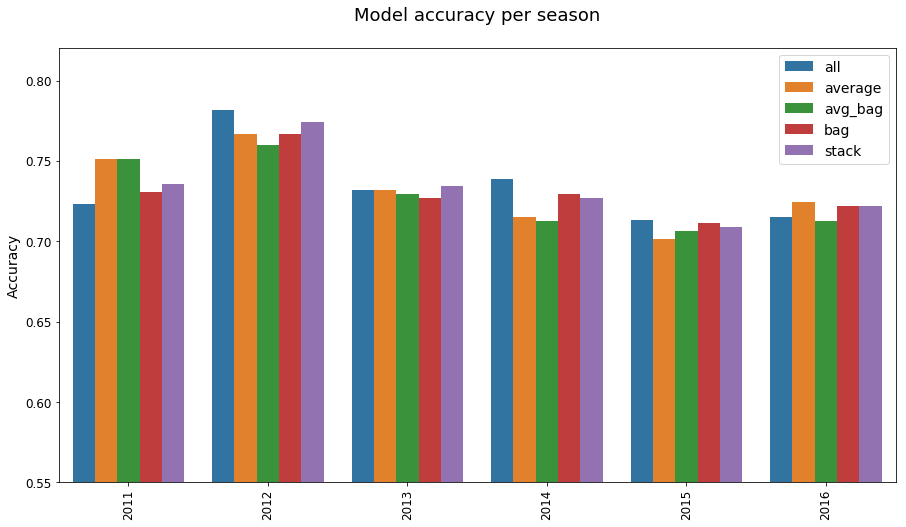

In [13]:
graph_yearly_model_performance(year_scores2)

In [14]:
year_scores2.groupby('model').mean()

,accuracy,error,year
model,,,
all,0.734035,28.933044,2013.5
average,0.731871,28.620735,2013.5
avg_bag,0.728648,28.690994,2013.5
bag,0.731278,28.789467,2013.5
stack,0.733747,29.508525,2013.5


In [15]:
year_scores2.groupby('model').std()

,accuracy,error,year
model,,,
all,0.025258,1.381807,1.870829
average,0.023971,1.231281,1.870829
avg_bag,0.022335,1.153029,1.870829
bag,0.018885,1.372004,1.870829
stack,0.022137,1.348018,1.870829


### Averaging bagged models doesn't make much of a difference vs just averaging
Also, it adds to training time, so it's not worth the trouble

## Averaging more models

In [16]:
MORE_ESTIMATORS = [
    Ridge(),
    GradientBoostingRegressor(),
    LinearSVR(),
    XGBRegressor(),
    Lasso(),
    RandomForestRegressor(n_estimators=100),
]

big_avg_models = []

for estimator in MORE_ESTIMATORS:
    model = AllModel(estimators=(StandardScaler(), estimator), name=type(estimator).__name__)
    big_avg_models.append(model)

big_avg_model = AveragingRegressor(big_avg_models)

In [17]:
big_avg_year_scores = yearly_performance_scores([('big_avg', big_avg_model, False)], features, labels)
year_scores3 = pd.concat([year_scores, big_avg_year_scores]).sort_values(['year', 'model'])
year_scores3

,accuracy,error,model,year
0,0.723077,30.612743,all,2011
1,0.751282,29.346211,average,2011
3,0.730769,30.293917,bag,2011
0,0.748718,29.600705,big_avg,2011
2,0.735897,30.825910,stack,2011
4,0.781553,28.431429,all,2012
5,0.766990,27.790045,average,2012
7,0.766990,28.456500,bag,2012
1,0.771845,28.132263,big_avg,2012
6,0.774272,28.769952,stack,2012


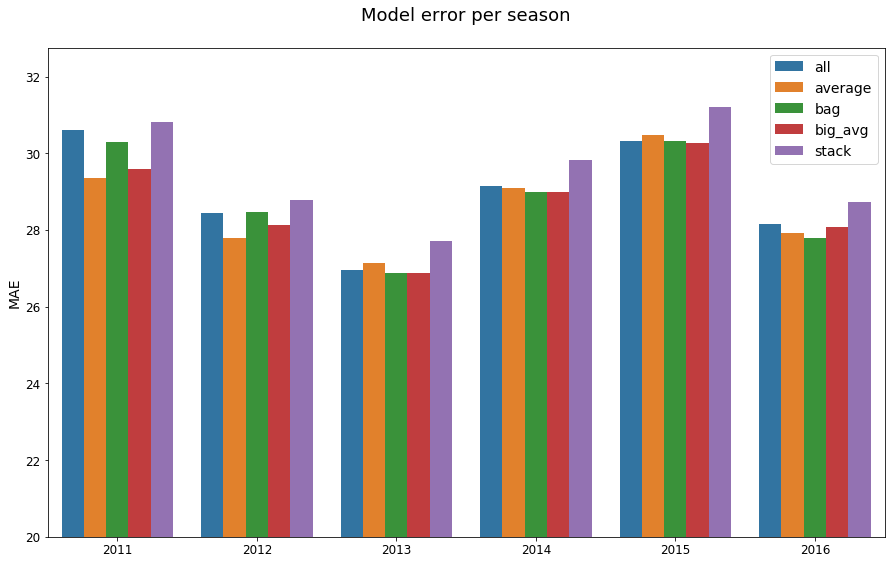

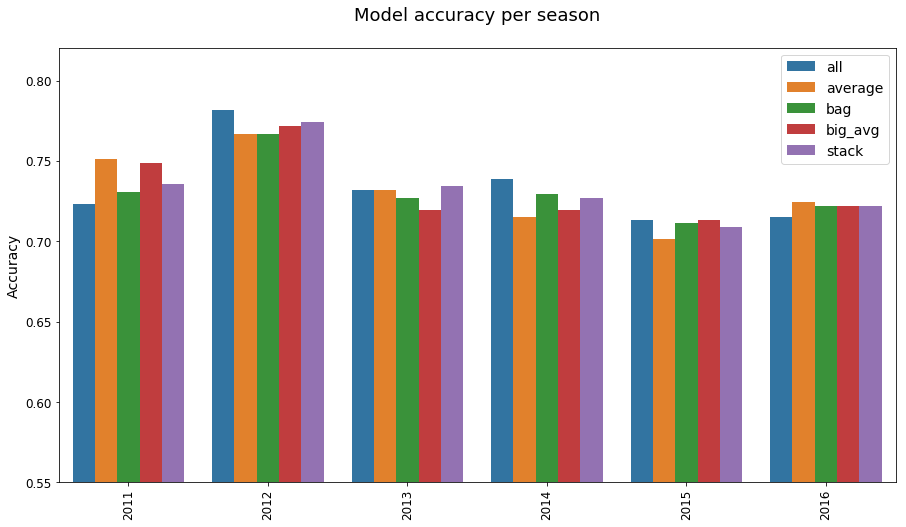

In [18]:
graph_yearly_model_performance(year_scores3)

In [19]:
year_scores3.groupby('model').mean()

,accuracy,error,year
model,,,
all,0.734035,28.933044,2013.5
average,0.731871,28.620735,2013.5
bag,0.731278,28.789467,2013.5
big_avg,0.732665,28.660161,2013.5
stack,0.733747,29.508525,2013.5


In [20]:
year_scores3.groupby('model').std()

,accuracy,error,year
model,,,
all,0.025258,1.381807,1.870829
average,0.023971,1.231281,1.870829
bag,0.018885,1.372004,1.870829
big_avg,0.022787,1.215466,1.870829
stack,0.022137,1.348018,1.870829


### Adding more models doesn't make much of a difference
But it does seem to help with accuracy a little, and the more the merrier. Also, tuning weights should improve performance a bit. So, going forward, I'll use averaging with 6 models.